# Lab 5


## JMuBEN2 dataset


(https://data.mendeley.com/datasets/tgv3zb82nd/1)

Image dataset taken from an Arabica coffee plantation. The image dataset contains collection of healthy and miner coffee leaves.

We used the same dataset that we used in Lab 4.

# Loading and Spliting the dataset 

In [2]:
import os
import requests
import zipfile
import numpy as np

dataset_url = 'https://github.com/ishaqmarashy/DATALFS/raw/main/JMuBEN.zip'
dataset_dir = './JMuBEN'

# create directory for dataset if it does not exist
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    
# append JMuBEN.zip to the end of the path (this is where we download the file to)
zip_file_path = os.path.join(dataset_dir, 'JMuBEN.zip')


# check if file is downloaded already
if not os.path.exists(zip_file_path):
    
    # file is not downloaded so fetch the file
    response = requests.get(dataset_url)
    
    # write file to storage which is recieved from the response
    with open(zip_file_path, 'wb') as zip_file:
        zip_file.write(response.content)
        
    # unzip to zip file path
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)

# within the concat train and test to become ./JMuBEN/train and JMuBEN ./JMuBEN/test
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

In [3]:
def load_images_and_labels(directory):
    images = []
    labels = []
    
    # get subdirectories Healthy and Miner
    
    for class_name in os.listdir(directory):
        
        # concat subdirectory to get full path
        class_dir = os.path.join(directory, class_name)
        # assign labels using class subdirectory
        # label is determined by filepath
        label = 0 if class_name == 'Miner' else 1
        
        # append labels and image paths to labels and images respectively
        for filename in os.listdir(class_dir):
            images.append(os.path.join(class_dir, filename))
            labels.append(label)
            
    return images, labels

# load file directories and their labels
train_images_dir, train_labels = load_images_and_labels(train_dir)
test_images_dir, test_labels = load_images_and_labels(test_dir)

In [4]:
# print the number of images and labels

print(f"Train images:{len(train_images_dir)}  Labels:{len(train_labels)}")
print(f"Test images:{len(test_images_dir)}  Labels:{len(test_labels)}")


Train images:24000  Labels:24000
Test images:6000  Labels:6000


# Pre-processing and Normalization

Images in the dataset were converted to grayscale and resized to 128x128

Tried loading as described https://www.analyticsvidhya.com/blog/2021/07/step-by-step-guide-for-image-classification-on-custom-datasets/

https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156

In [5]:
import cv2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

def load_grayscale_images(image_paths):
    loaded_images = []
    for image_path in image_paths:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  #  grayscale
        loaded_images.append(img)
    return loaded_images

def resize_images(images_to_resize):
    resized_images = []
    for img in images_to_resize:
        resized_img = cv2.resize(img, (48, 48))  # resize
        resized_images.append(resized_img)
    return resized_images

def normalize_image(images_to_normalize):
    normalized_images = []
    for img in images_to_normalize:
        normalized_img = img / 255.0  # normalize
        normalized_images.append(normalized_img)
    return normalized_images

image_pipeline = Pipeline(steps=[
    ('load_grayscale_images', FunctionTransformer(load_grayscale_images)),
    ('resize_images', FunctionTransformer(resize_images)),
    ('normalize_image', FunctionTransformer(normalize_image))
])


train_images=image_pipeline.transform(train_images_dir)
test_images=image_pipeline.transform(test_images_dir)

In [6]:
print(len(train_images))
print(len(test_images))

24000
6000


# Model Training

In [7]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)

train_images = train_images.reshape(train_images.shape[0], -1)
train_labels = train_labels.reshape(train_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

### 1) Multinomial Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
clf1 = MultinomialNB(alpha=1.0e-10, force_alpha=True , class_prior=[0.4, 0.6])
train_labels = train_labels.ravel()
clf1.fit(train_images, train_labels)
predictions1 = clf1.predict(test_images)

##### Model Evaluation


In [9]:
from sklearn.metrics import accuracy_score

# accuracy
accuracy = accuracy_score(test_labels, predictions1)
print('Accuracy = ', accuracy)

Accuracy =  0.6556666666666666


In [10]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix = confusion_matrix(test_labels, predictions1)
confusion_matrix

array([[1068, 1932],
       [ 134, 2866]], dtype=int64)

In [11]:
tp = confusion_matrix[0,0]
print("TP = ", tp)
fp = confusion_matrix[1,0]
print("FP = ", fp)
tn = confusion_matrix[1,1]
print("TN = ", tn)
fn = confusion_matrix[0,1]
print("FN = ", fn)

TP =  1068
FP =  134
TN =  2866
FN =  1932


In [12]:
sensitivity = tp / (tp + fn)
print('Sensitivity = ', sensitivity)

specificity = tn/ (fp + tn)
print('Specificity = ', specificity)

Sensitivity =  0.356
Specificity =  0.9553333333333334


In [13]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(test_labels, predictions1)
print('Precision = ', precision)

recall = recall_score(test_labels, predictions1)
print('Recall = ', recall)

Precision =  0.5973322217590663
Recall =  0.9553333333333334


Area Under Curve =  0.5523554444444445


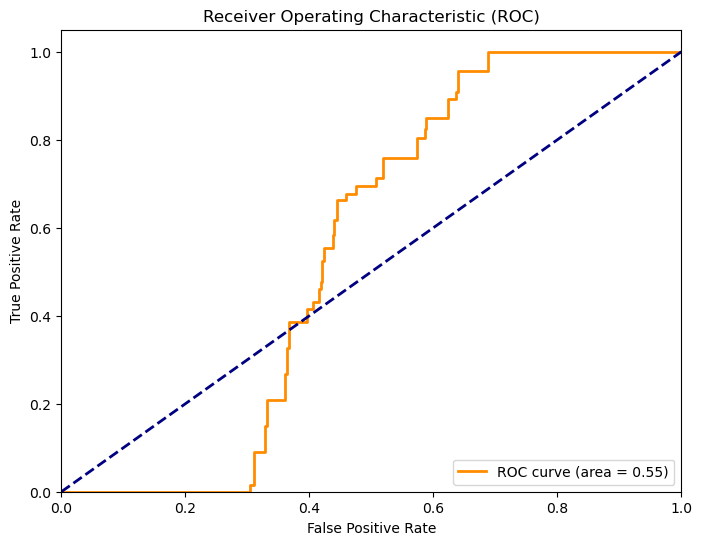

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate predicted probabilities for the positive class
probabilities = clf1.predict_proba(test_images)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("Area Under Curve = ", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### 2) Gaussian Naive Bayes

In [15]:
from sklearn.naive_bayes import GaussianNB
clf2 = GaussianNB()
clf2.fit(train_images, train_labels)
predictions2 = clf2.predict(test_images)

##### Model Evaluation


In [16]:
# accuracy
accuracy = accuracy_score(test_labels, predictions2)
print('Accuracy = ', accuracy)

Accuracy =  0.653


In [17]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix = confusion_matrix(test_labels, predictions2)
confusion_matrix

array([[2316,  684],
       [1398, 1602]], dtype=int64)

In [18]:
tp = confusion_matrix[0,0]
print("TP = ", tp)
fp = confusion_matrix[1,0]
print("FP = ", fp)
tn = confusion_matrix[1,1]
print("TN = ", tn)
fn = confusion_matrix[0,1]
print("FN = ", fn)

TP =  2316
FP =  1398
TN =  1602
FN =  684


In [19]:
sensitivity = tp / (tp + fn)
print('Sensitivity = ', sensitivity)

specificity = tn/ (fp + tn)
print('Specificity = ', specificity)

Sensitivity =  0.772
Specificity =  0.534


In [20]:
precision = precision_score(test_labels, predictions2)
print('Precision = ', precision)

recall = recall_score(test_labels, predictions2)
print('Recall = ', recall)

Precision =  0.7007874015748031
Recall =  0.534


Area Under Curve =  0.782322


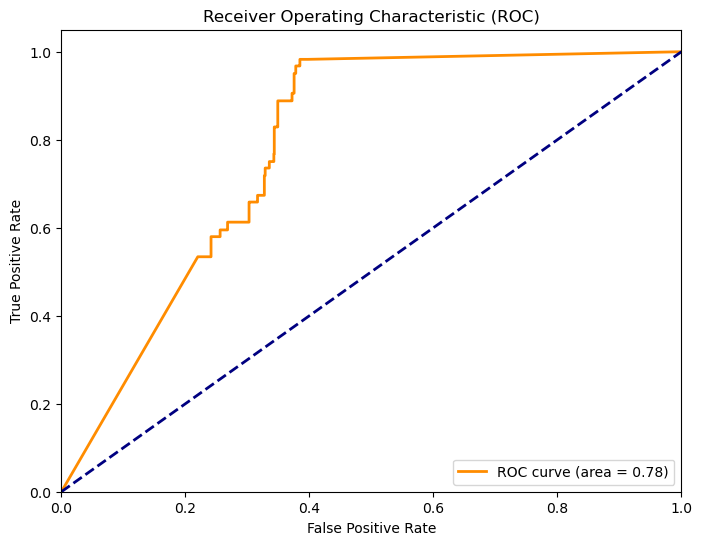

In [21]:
# Calculate predicted probabilities for the positive class
probabilities = clf2.predict_proba(test_images)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("Area Under Curve = ", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### 3) Complement Naive Bayes

In [22]:
from sklearn.naive_bayes import ComplementNB
clf3 = ComplementNB(force_alpha=True)
clf3.fit(train_images, train_labels)
predictions3 = clf3.predict(test_images)

##### Model Evaluation


In [23]:
# accuracy
accuracy = accuracy_score(test_labels, predictions3)
print('Accuracy = ', accuracy)

Accuracy =  0.601


In [24]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix = confusion_matrix(test_labels, predictions3)
confusion_matrix

array([[1331, 1669],
       [ 725, 2275]], dtype=int64)

In [25]:
tp = confusion_matrix[0,0]
print("TP = ", tp)
fp = confusion_matrix[1,0]
print("FP = ", fp)
tn = confusion_matrix[1,1]
print("TN = ", tn)
fn = confusion_matrix[0,1]
print("FN = ", fn)

TP =  1331
FP =  725
TN =  2275
FN =  1669


In [26]:
sensitivity = tp / (tp + fn)
print('Sensitivity = ', sensitivity)

specificity = tn/ (fp + tn)
print('Specificity = ', specificity)

Sensitivity =  0.44366666666666665
Specificity =  0.7583333333333333


In [27]:
precision = precision_score(test_labels, predictions3)
print('Precision = ', precision)

recall = recall_score(test_labels, predictions3)
print('Recall = ', recall)

Precision =  0.5768255578093306
Recall =  0.7583333333333333


Area Under Curve =  0.552383888888889


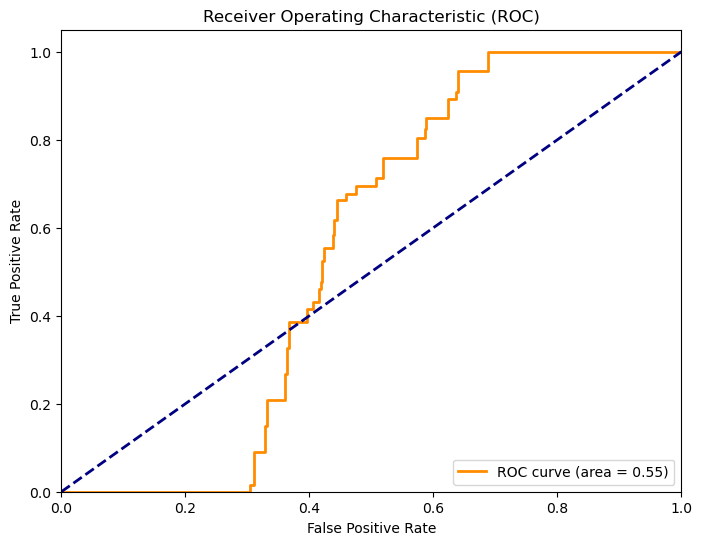

In [28]:
# Calculate predicted probabilities for the positive class
probabilities = clf3.predict_proba(test_images)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("Area Under Curve = ", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### 4) Bernoulli Naive Bayes

In [29]:
from sklearn.naive_bayes import BernoulliNB
clf4 = BernoulliNB(force_alpha=True)
clf4.fit(train_images, train_labels)
predictions4 = clf4.predict(test_images)

##### Model Evaluation


In [30]:
# accuracy
accuracy = accuracy_score(test_labels, predictions4)
print('Accuracy = ', accuracy)

Accuracy =  0.5


In [31]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix = confusion_matrix(test_labels, predictions4)
confusion_matrix

array([[3000,    0],
       [3000,    0]], dtype=int64)

In [32]:
tp = confusion_matrix[0,0]
print("TP = ", tp)
fp = confusion_matrix[1,0]
print("FP = ", fp)
tn = confusion_matrix[1,1]
print("TN = ", tn)
fn = confusion_matrix[0,1]
print("FN = ", fn)

TP =  3000
FP =  3000
TN =  0
FN =  0


In [33]:
sensitivity = tp / (tp + fn)
print('Sensitivity = ', sensitivity)

specificity = tn/ (fp + tn)
print('Specificity = ', specificity)

Sensitivity =  1.0
Specificity =  0.0


In [34]:
precision = precision_score(test_labels, predictions4, zero_division=1)
print('Precision = ', precision)

recall = recall_score(test_labels, predictions4, zero_division=1)
print('Recall = ', recall)

Precision =  1.0
Recall =  0.0


Area Under Curve =  0.5


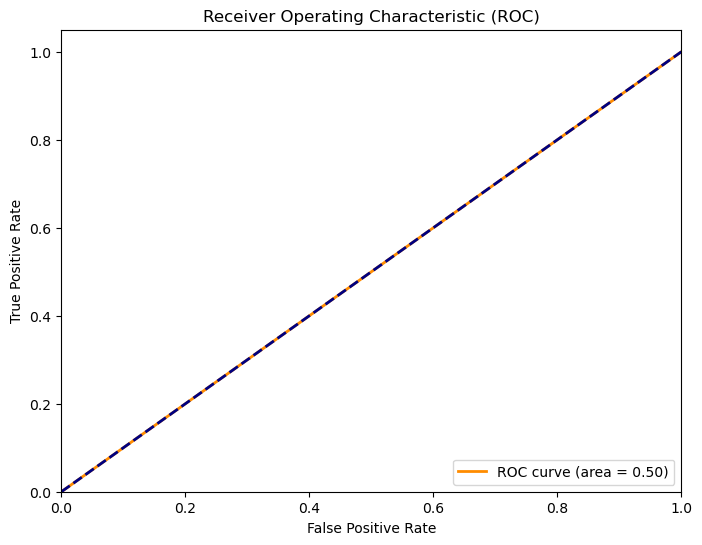

In [35]:
# Calculate predicted probabilities for the positive class
probabilities = clf4.predict_proba(test_images)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("Area Under Curve = ", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### 5) Categorical Naive Bayes

In [36]:
from sklearn.naive_bayes import CategoricalNB
clf5 = CategoricalNB(force_alpha=True)
clf5.fit(train_images, train_labels)
predictions5 = clf5.predict(test_images)

##### Model Evaluation


In [37]:
# accuracy
accuracy = accuracy_score(test_labels, predictions5)
print('Accuracy = ', accuracy)

Accuracy =  0.6163333333333333


In [38]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix = confusion_matrix(test_labels, predictions5)
confusion_matrix

array([[ 698, 2302],
       [   0, 3000]], dtype=int64)

In [39]:
tp = confusion_matrix[0,0]
print("TP = ", tp)
fp = confusion_matrix[1,0]
print("FP = ", fp)
tn = confusion_matrix[1,1]
print("TN = ", tn)
fn = confusion_matrix[0,1]
print("FN = ", fn)

TP =  698
FP =  0
TN =  3000
FN =  2302


In [40]:
sensitivity = tp / (tp + fn)
print('Sensitivity = ', sensitivity)

specificity = tn/ (fp + tn)
print('Specificity = ', specificity)

Sensitivity =  0.23266666666666666
Specificity =  1.0


In [41]:
precision = precision_score(test_labels, predictions5)
print('Precision = ', precision)

recall = recall_score(test_labels, predictions5)
print('Recall = ', recall)

Precision =  0.5658242172764995
Recall =  1.0


Area Under Curve =  0.6285


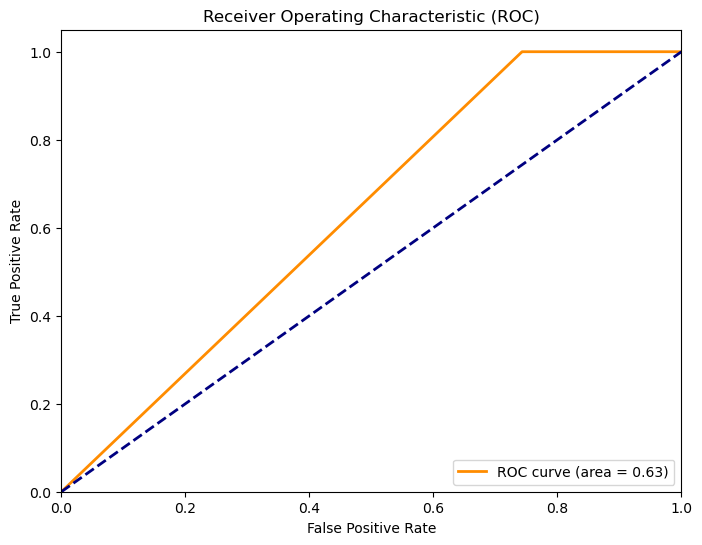

In [42]:
# Calculate predicted probabilities for the positive class
probabilities = clf5.predict_proba(test_images)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("Area Under Curve = ", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [43]:
X=train_images

# Clustering


In [44]:
X=test_images
y=test_labels

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def calculate_metrics(y, cluster_labels):
    cm = confusion_matrix(y, cluster_labels)
    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]
    Sensitivity = TP / (TP + FN)
    Specificity = TN / (TN + FP)
    fpr= TP / (TP + FN)
    tpr= Sensitivity
    silhouette_scores = silhouette_score(X, cluster_labels)
    F1_score = f1_score(y, cluster_labels)
    roc_auc = roc_auc_score(y, cluster_labels)
    Precision = precision_score(y, cluster_labels)
    Recall = recall_score(y, cluster_labels)
    accuracy = accuracy_score(y, cluster_labels)

    return fpr, tpr, TP, FP, TN, FN, Sensitivity, Specificity, Precision, Recall, roc_auc, accuracy, F1_score, silhouette_scores

k_clusters=2
algorithms = [
    ('GM', GaussianMixture(n_components=k_clusters)),
    ('K-Means', KMeans(n_clusters=k_clusters, n_init="auto")),
    ('MiniBatchKMeans', MiniBatchKMeans(n_clusters=k_clusters, batch_size=1536 , init='k-means++', n_init=50)), 
    ('AgglomerativeClustering', AgglomerativeClustering(n_clusters=k_clusters))
]

def evaluate_unsupervised(algorithms,X):
    results = []
    for name, algorithm in algorithms:
        cluster_labels = algorithm.fit_predict(X)
        fpr, tpr, TP, FP, TN, FN, Sensitivity, Specificity, Precision, Recall, roc_auc, accuracy, F1_score, silhouette_score_ = calculate_metrics(y, cluster_labels)
        print(name,' Done')
        results.append({
            'Algorithm': name,
            'Silhouette Score': silhouette_score_,
            'TPR': tpr,
            'FPR': fpr,
            'TP': TP,
            'FP': FP,
            'TN': TN,
            'FN': FN,
            'Sensitivity': Sensitivity,
            'Specificity': Specificity,
            'Precision': Precision,
            'Recall': Recall,
            'ROC_AUC': roc_auc,
            'Accuracy': accuracy,
            'F1-Score': F1_score,
            f'Data {X.shape[1]} Features' : X,
            'algorithm':algorithm
        })
    return pd.DataFrame(results)


In [46]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [47]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [48]:
results_df_full_feature = evaluate_unsupervised(algorithms,X)
results_df_full_feature

GM  Done
K-Means  Done
MiniBatchKMeans  Done
AgglomerativeClustering  Done


,Algorithm,Silhouette Score,TPR,FPR,TP,FP,TN,FN,Sensitivity,Specificity,Precision,Recall,ROC_AUC,Accuracy,F1-Score,Data 2304 Features,algorithm
0,GM,0.392455,0.534,0.534,1602,831,2169,1398,0.534,0.723000,0.658446,0.534,0.628500,0.628500,0.589729,"[[0.3764705882352941, 0.35294117647058826, 0.3...",GaussianMixture(n_components=2)
1,K-Means,0.392962,0.466,0.466,1398,2185,815,1602,0.466,0.271667,0.390176,0.466,0.368833,0.368833,0.424730,"[[0.3764705882352941, 0.35294117647058826, 0.3...","KMeans(n_clusters=2, n_init='auto')"
2,MiniBatchKMeans,0.393025,0.466,0.466,1398,2201,799,1602,0.466,0.266333,0.388441,0.466,0.366167,0.366167,0.423701,"[[0.3764705882352941, 0.35294117647058826, 0.3...","MiniBatchKMeans(batch_size=1536, n_clusters=2,..."
3,AgglomerativeClustering,0.383456,0.534,0.534,1602,515,2485,1398,0.534,0.828333,0.756731,0.534,0.681167,0.681167,0.626148,"[[0.3764705882352941, 0.35294117647058826, 0.3...",AgglomerativeClustering()


In [49]:
results_df_full_PCA= evaluate_unsupervised(algorithms,X_pca)
results_df_full_PCA

GM  Done
K-Means  Done
MiniBatchKMeans  Done
AgglomerativeClustering  Done


,Algorithm,Silhouette Score,TPR,FPR,TP,FP,TN,FN,Sensitivity,Specificity,Precision,Recall,ROC_AUC,Accuracy,F1-Score,Data 2 Features,algorithm
0,GM,0.336431,0.534,0.534,1602,24,2976,1398,0.534,0.992000,0.985240,0.534,0.763000,0.763000,0.692607,"[[3.0278309162486527, 0.7855100118660826], [3....",GaussianMixture(n_components=2)
1,K-Means,0.393031,0.534,0.534,1602,795,2205,1398,0.534,0.735000,0.668335,0.534,0.634500,0.634500,0.593663,"[[3.0278309162486527, 0.7855100118660826], [3....","KMeans(n_clusters=2, n_init='auto')"
2,MiniBatchKMeans,0.393031,0.466,0.466,1398,2205,795,1602,0.466,0.265000,0.388010,0.466,0.365500,0.365500,0.423444,"[[3.0278309162486527, 0.7855100118660826], [3....","MiniBatchKMeans(batch_size=1536, n_clusters=2,..."
3,AgglomerativeClustering,0.384317,0.534,0.534,1602,506,2494,1398,0.534,0.831333,0.759962,0.534,0.682667,0.682667,0.627251,"[[3.0278309162486527, 0.7855100118660826], [3....",AgglomerativeClustering()


In [50]:
results_df_full_tsne = evaluate_unsupervised(algorithms,X_tsne)
results_df_full_tsne

GM  Done
K-Means  Done
MiniBatchKMeans  Done
AgglomerativeClustering  Done


,Algorithm,Silhouette Score,TPR,FPR,TP,FP,TN,FN,Sensitivity,Specificity,Precision,Recall,ROC_AUC,Accuracy,F1-Score,Data 2 Features,algorithm
0,GM,0.181472,0.303667,0.303667,911,1990,1010,2089,0.303667,0.336667,0.314030,0.303667,0.320167,0.320167,0.308761,"[[19.466763, -3.0926719], [-68.44903, 96.48294...",GaussianMixture(n_components=2)
1,K-Means,0.187447,0.696333,0.696333,2089,950,2050,911,0.696333,0.683333,0.687397,0.696333,0.689833,0.689833,0.691836,"[[19.466763, -3.0926719], [-68.44903, 96.48294...","KMeans(n_clusters=2, n_init='auto')"
2,MiniBatchKMeans,0.173089,0.331667,0.331667,995,2112,888,2005,0.331667,0.296000,0.320245,0.331667,0.313833,0.313833,0.325856,"[[19.466763, -3.0926719], [-68.44903, 96.48294...","MiniBatchKMeans(batch_size=1536, n_clusters=2,..."
3,AgglomerativeClustering,0.069482,0.361667,0.361667,1085,902,2098,1915,0.361667,0.699333,0.546049,0.361667,0.530500,0.530500,0.435131,"[[19.466763, -3.0926719], [-68.44903, 96.48294...",AgglomerativeClustering()
